In [ ]:
!pip install optuna

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme('notebook')
sns.set_palette('Set2')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

In [6]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('drive/My Drive/Colab Notebooks/_train_sem09 (1).csv')
data.head()

Mounted at /content/drive


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


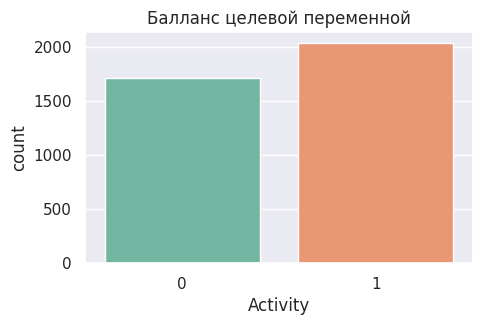

In [7]:
plt.figure(figsize=(5,3))
sns.countplot(data=data, x='Activity')
plt.title('Балланс целевой переменной');

In [8]:
x = data.drop(columns='Activity')
y = data['Activity']

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
#Зафиксируем метрики наших моделей с гиперпараметрами по умолчанию
log_regr = LogisticRegression(max_iter=1000, random_state=42)
random_forest = RandomForestClassifier(random_state=42)

log_regr.fit(x_train, y_train)
random_forest.fit(x_train, y_train)

y_test_pred_lr = log_regr.predict(x_test)
print(f'f1_score на тестовом наборе LogisticRegression: {round(metrics.f1_score(y_test, y_test_pred_lr),2)}')
y_test_pred_rf = log_regr.predict(x_test)
print(f'f1_score на тестовом наборе RandomForestClassifier: {round(metrics.f1_score(y_test, y_test_pred_rf),2)}')

f1_score на тестовом наборе LogisticRegression: 0.79
f1_score на тестовом наборе RandomForestClassifier: 0.79


## <center> **GridSearchCV**

In [ ]:
param_grid = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'saga', 'sag'],}

grid_search = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000,random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs = -1
)

%time grid_search.fit(x_train, y_train)
y_test_pred = grid_search.predict(x_test)

print(f'LogisticRegression\nf1_score на тестовом наборе: {round(metrics.f1_score(y_test, y_test_pred),2)}')
print(f"Наилучшие значения гиперпараметров: {grid_search.best_params_}")

CPU times: user 6.23 s, sys: 1.34 s, total: 7.56 s
Wall time: 10min
LogisticRegression
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'lbfgs'}


In [ ]:
param_grid = {'n_estimators': list(range(100, 200, 20)),
              'min_samples_leaf': [5, 7, 10],
              'max_depth':  [10, 15, 20, 25]
              }

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv = 5
)

%time grid_search.fit(x_train, y_train)
y_test_pred = grid_search.predict(x_test)

print(f'RandomForestClassifier\nf1_score на тестовом наборе: {round(metrics.f1_score(y_test, y_test_pred),2)}')
print(f"Наилучшие значения гиперпараметров: {grid_search.best_params_}")

CPU times: user 7min 3s, sys: 1.37 s, total: 7min 4s
Wall time: 7min 43s
RandomForestClassifier
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 120}


## <center> RandomizedSearchCV

In [ ]:
param_distributions = [{'penalty': ['l2', 'none'] ,
                        'solver': ['lbfgs', 'saga', 'sag', 'newton-cholesky'],
                        'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},

                       {'penalty': ['l1', 'l2'] ,
                        'solver': ['liblinear', 'saga'],
                        'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}]

random_search = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=1000,random_state=42),
    param_distributions=param_distributions,
    cv=5,
    n_iter = 15,
    n_jobs = -1
)

%time random_search.fit(x_train, y_train)
y_test_pred = random_search.predict(x_test)

print(f'LogisticRegression\nf1_score на тестовом наборе: {round(metrics.f1_score(y_test, y_test_pred),2)}')
print(f"Наилучшие значения гиперпараметров: {random_search.best_params_}")

CPU times: user 7.12 s, sys: 1.61 s, total: 8.73 s
Wall time: 16min 57s
LogisticRegression
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.9}


In [ ]:
param_distributions = {'n_estimators': list(range(100, 200, 20)),
                       'min_samples_leaf': [5, 7, 10],
                       'max_depth':  [10, 15, 20, 25, 30]}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    cv = 5,
    n_iter = 10,
    n_jobs = -1
)

%time random_search.fit(x_train, y_train)
y_test_pred = random_search.predict(x_test)

print(f'RandomForestClassifier\nf1_score на тестовом наборе: {round(metrics.f1_score(y_test, y_test_pred),2)}')
print(f"Наилучшие значения гиперпараметров: {random_search.best_params_}")

CPU times: user 2.39 s, sys: 227 ms, total: 2.62 s
Wall time: 58.3 s
RandomForestClassifier
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'n_estimators': 120, 'min_samples_leaf': 5, 'max_depth': 15}


## <center> Hyperopt

### RandomForestClassifier

In [7]:
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 10, 30, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)}

In [15]:
def hyperopt_rf(params, cv=5, X=x_train, y=y_train, random_state=42):
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
             'min_samples_leaf': int(params['min_samples_leaf'])}

    model = RandomForestClassifier(**params, random_state=random_state)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    return -score

In [16]:
%%time
trials = Trials()

best = fmin(hyperopt_rf,
            space=space,
            max_evals=20,
            trials=trials,
            rstate=np.random.default_rng(42))

print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [02:49<00:00,  8.48s/trial, best loss: -0.8078298916073153]
Наилучшие значения гиперпараметров {'max_depth': 16.0, 'min_samples_leaf': 3.0, 'n_estimators': 150.0}
CPU times: user 2.38 s, sys: 971 ms, total: 3.35 s
Wall time: 2min 49s


In [17]:
%%time
best=fmin(hyperopt_rf,
          space=space,
          max_evals=25,
          trials=trials,
          rstate=np.random.default_rng(42))

print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 25/25 [00:50<00:00, 10.08s/trial, best loss: -0.8084853865650283]
Наилучшие значения гиперпараметров {'max_depth': 16.0, 'min_samples_leaf': 2.0, 'n_estimators': 160.0}
CPU times: user 730 ms, sys: 253 ms, total: 983 ms
Wall time: 50.4 s


In [25]:
model = RandomForestClassifier(
    random_state=42,
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf']))

model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)
print(f'RandomForestClassifier\nf1_score на тестовом наборе: {round(metrics.f1_score(y_test, y_test_pred),2)}')


RandomForestClassifier
f1_score на тестовом наборе: 0.83


### LogisticRegression

In [67]:
pen = ['l1', 'l2']
sol = ['liblinear', 'saga']
space={'penalty': hp.choice('penalty', ['l1', 'l2']),
       'solver': hp.choice('solver', ['liblinear', 'saga']),
       'C': hp.uniform('C', low=0.01, high=1)}

In [68]:
def hyperopt_lr(params, cv=5, X=x_train, y=y_train, random_state=42):
    params = {'penalty': str(params['penalty']),
              'solver': str(params['solver']),
              'C': float(params['C'])}

    model = LogisticRegression(**params, random_state=random_state)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    return -score

In [69]:
%%time
trials = Trials()

best = fmin(hyperopt_lr,
            space=space,
            max_evals=20,
            trials=trials,
            rstate=np.random.default_rng(42))

print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [07:15<00:00, 21.75s/trial, best loss: -0.7829988360696984]
Наилучшие значения гиперпараметров {'C': 0.7327392043584334, 'penalty': 0, 'solver': 0}
CPU times: user 4.72 s, sys: 1.45 s, total: 6.16 s
Wall time: 7min 15s


In [70]:
model = LogisticRegression(
    random_state=42,
    penalty=pen[best['penalty']],
    solver=sol[best['solver']],
    C=float(best['C']))

model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)
print(f'LogisticRegression\nf1_score на тестовом наборе: {round(metrics.f1_score(y_test, y_test_pred),2)}')

LogisticRegression
f1_score на тестовом наборе: 0.79


## <center> Optuna

### RandomForestClassifier

In [23]:
def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 5, 50, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = RandomForestClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_leaf=min_samples_leaf,
                                 random_state=42)

  model.fit(x_train, y_train)
  score = metrics.f1_score(y_train, model.predict(x_train))

  return score

In [24]:
%%time
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

[I 2023-08-28 09:13:00,759] A new study created in memory with name: RandomForestClassifier
[I 2023-08-28 09:13:02,600] Trial 0 finished with value: 0.8176020408163266 and parameters: {'n_estimators': 179, 'max_depth': 6, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8176020408163266.
[I 2023-08-28 09:13:06,176] Trial 1 finished with value: 0.9564676616915422 and parameters: {'n_estimators': 183, 'max_depth': 41, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9564676616915422.
[I 2023-08-28 09:13:07,877] Trial 2 finished with value: 0.917260613572978 and parameters: {'n_estimators': 107, 'max_depth': 45, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.9564676616915422.
[I 2023-08-28 09:13:10,618] Trial 3 finished with value: 0.9098258706467661 and parameters: {'n_estimators': 131, 'max_depth': 15, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.9564676616915422.
[I 2023-08-28 09:13:12,647] Trial 4 finished with value: 0.785897435897436 and parameters: {'n_est

CPU times: user 1min 1s, sys: 320 ms, total: 1min 1s
Wall time: 1min 2s


In [28]:
model = RandomForestClassifier(**study.best_params,random_state=42)
model.fit(x_train, y_train)

y_test_pred = model.predict(x_test)
print(f'RandomForestClassifier\nf1_score на тестовом наборе: {round(metrics.f1_score(y_test, y_test_pred),2)}')
print(f'Наилучшие значения гиперпараметров {study.best_params}')

RandomForestClassifier
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 35, 'min_samples_leaf': 2}


### LogisticRegression

In [4]:
def optuna_rf(trial):
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
  C = trial.suggest_float('C', 0.01, 1)

  model = LogisticRegression(penalty=penalty,
                                 solver=solver,
                                 C=C,
                                 random_state=42)

  model.fit(x_train, y_train)
  score = metrics.f1_score(y_train, model.predict(x_train))

  return score

In [11]:
%%time
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

[I 2023-08-28 17:27:24,644] A new study created in memory with name: LogisticRegression
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-08-28 17:27:34,009] Trial 0 finished with value: 0.8574062692071298 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.14448715420781874}. Best is trial 0 with value: 0.8574062692071298.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-08-28 17:27:45,360] Trial 1 finished with value: 0.8376068376068376 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.31950259521438834}. Best is trial 0 with value: 0.8574062692071298.
[I 2023-08-28 17:27:45,994] Trial 2 finished with value: 0.8860759493670887 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.9346124405348196

CPU times: user 1min 1s, sys: 2.28 s, total: 1min 3s
Wall time: 1min 3s


In [12]:
model = LogisticRegression(**study.best_params,random_state=42)
model.fit(x_train, y_train)

y_test_pred = model.predict(x_test)
print(f'LogisticRegression\nf1_score на тестовом наборе: {round(metrics.f1_score(y_test, y_test_pred),2)}')
print(f'Наилучшие значения гиперпараметров {study.best_params}')

LogisticRegression
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.9986957782987234}
